# MLP in PyTorch on a subset of MNIST.
In this notebook you will work on training an MLP on the MNIST dataset. Here, the module class is introducend and you will become familiar with a more flexible way of defining models in PyTorch than the sequential container.

### MNIST dataset:
The MNIST dataset is a widely used benchmark dataset in the field of machine learning, particularly in the domain of image classification. It consists of a collection of 28x28 pixel grayscale images depicting handwritten digits from 0 to 9. Originally created to train and test the performance of various machine learning algorithms, MNIST has become a standard dataset for assessing the capabilities of new models. In scikit-learn, the MNIST dataset is conveniently accessible through the fetch_openml function, where each image is flattened into a one-dimensional array of 784 elements (28x28 pixels). The associated labels represent the corresponding digit for each image, allowing for straightforward integration with various classification algorithms.

### Loading the dataset
In the code below, the data is loaded from scikit learn and a PyTorch dataloader is created on a subset of the data containing 1000 samples.

The code starts by importing necessary libraries, including PyTorch, torchvision, and matplotlib.
The MNIST dataset is loaded and transformed into PyTorch tensors using transforms.ToTensor().
A subset of the dataset is created to speed up training. This can be adjusted based on available computational resources.
Finally, a DataLoader is created for the training and testing sets. This is done for efficient batch processing.

In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
torch.manual_seed(42)

# Load the Optical Recognition of Handwritten Digits dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Subset the dataset for faster training (optional)
subset_size = 15000
subset, _ = random_split(full_dataset, [subset_size, len(full_dataset) - subset_size])

# Split into train and test sets
train_size = int(0.8 * len(subset))
test_size = len(subset) - train_size
train_dataset, test_dataset = random_split(subset, [train_size, test_size])

# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100.0%
100.0%
100.0%
100.0%


### Data visualization:
Before we start working on the MLP and its training, we can visualize the data to get a better idea of the problem at hand. The code below addresses this. It a function visualize_dataset to visualize a random sample of the dataset. It then visualizes a small number of samples, displaying the handwritten digits along with their corresponding labels.

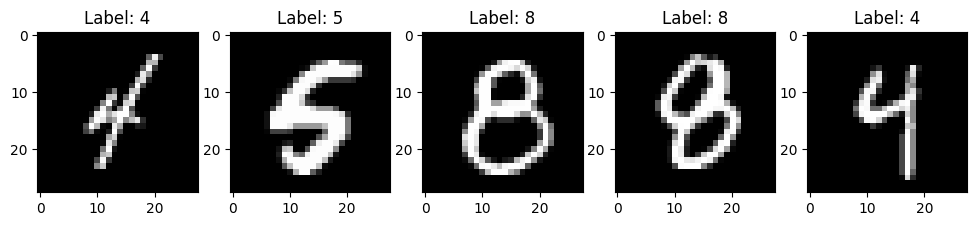

In [3]:
# Dataset Visualization
import matplotlib.pyplot as plt
# Function to visualize a random sample of the dataset
def visualize_dataset(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))

    for i in range(num_samples):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[sample_idx]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')

    plt.show()

# Visualize a random sample of the dataset
visualize_dataset(subset)


## Model definition

### The Module class: 
In PyTorch, the `nn.Module` class serves as a foundational building block for constructing and organizing neural network architectures. It provides a flexible and modular structure that allows users to define their custom models by subclassing `nn.Module`. The `nn.Module` class encapsulates both trainable parameters and the operations performed on input data, facilitating the design of complex and hierarchical models. Subclassing `nn.Module` requires implementing the `__init__` and `forward` methods, where the former initializes the model's components, and the latter defines the forward pass. This object-oriented approach offers a fine-grained level of control over the model's architecture, making it suitable for scenarios where more intricate designs and customization are necessary.


### Sequential as a Subclass of nn.Module

In PyTorch, `nn.Sequential` is a subclass of `nn.Module`, meaning it inherits all the functionalities of `nn.Module`, including parameter management, saving and loading models, and moving models to different devices (CPU/GPU). The key difference is that `nn.Sequential` provides an easy way to define models where the forward pass is simply a sequential execution of layers, without needing to explicitly define a `forward` method.

The `torch.nn.Sequential` module allows for building neural networks in a concise and modular way. The `Sequential` container stacks layers in the order they are defined, automatically passing the output of one layer as the input to the next.


#### Defining a Sequential Model

A `Sequential` model can be created using `torch.nn.Sequential`, where layers are added in the order they should be executed:

```python
import torch
import torch.nn as nn

# Define a simple feedforward network
model = nn.Sequential(
    nn.Linear(10, 20),  # Fully connected layer: input size 10, output size 20
    nn.ReLU(),          # Activation function
    nn.Linear(20, 5),   # Fully connected layer: input size 20, output size 5
)

print(model)`
```

### More general models 
Defining models by extending the `nn.Module` class in PyTorch can provide several advantages over using the `nn.Sequential` container. One key advantage is increased flexibility in designing complex architectures that involve branching, skipping connections, or any other non-sequential patterns. With the `nn.Module` approach, one can easily create models with shared parameters, reuse submodules, and incorporate conditional logic within the forward pass. This level of flexibility is particularly beneficial when dealing with intricate architectures common in advanced tasks such as image segmentation, object detection, or natural language processing. Additionally, subclassing `nn.Module` allows for better organization and encapsulation of model components, promoting modular and maintainable code structures. Overall, leveraging the `nn.Module` class offers a powerful and extensible framework for crafting sophisticated neural network architectures in PyTorch. We will focus on extending the `nn.Module` in later notebooks.


**Code:**
The below code defines an MLP model using the `nn.Module` class, with one hidden layer and a ReLU activation function using the `nn.Sequential`.
The input size is set based on the size of MNIST images (28x28 pixels), the hidden size is set to 64, and the output size corresponds to the number of classes (digits 0 to 9).

In [3]:
# Model Definition

import torch.nn as nn
import torch.optim as optim

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)





### Training cycle
Here, your task is to define and implement the training loop and necessary components to train the model. The training loos is to be imlemented in afunction `train_model`. The function takes as inputs the model to be trained (MLP_model) and the number of epochs (num_epochs), which determines how many times the entire dataset will be passed through the network during training. 

Below is a breakdown of the steps you need to take:

* Initialize the Loss Function and Optimizer:
    * Use CrossEntropyLoss as the loss function.
    * Use Stochastic Gradient Descent (SGD) as the optimizer.

* Training Loop:

    * Iterate over each epoch using for epoch in range(num_epochs): Initialize total_loss to 0 for each epoch.

    * Inner Loop for Batches: Iterate over batches of data from the training DataLoader (train_loader).

    * For each batch, perform the following steps: 
        * Zero the gradients using optimizer.zero_grad().
        * Flatten the input images if needed (in this case, using inputs.view(-1, 28 * 28)). 
        * Perform a forward pass through the model (outputs = model(inputs)). Compute the loss between the model predictions and the true labels (loss = criterion(outputs, labels)).
        * Perform a backward pass to compute gradients (loss.backward()).
        * Update the model parameters using the optimizer (optimizer.step()).
        * Accumulate the batch loss to the total loss.
    
    * Print Epoch Information: After each epoch, print the average loss over all batches in that epoch.

In [4]:
# Training Cycle

def train_model(MLP_model, num_epochs = 10):
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(MLP_model.parameters(), lr=0.01)
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            inputs = inputs.view(-1, 28 * 28)  # Flatten the images
            outputs = MLP_model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights

            total_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')


### Evaluating the Model
After training, we need to evaluate the model's performance on the test set.
Below, you need to implement the function `evaluate_model`.
In this function you need to do the following:

- **Set Model to Evaluation Mode:**
  - Inside the function, set the provided MLP model (`MLP_model`) to evaluation mode using `MLP_model.eval()`.

- **Perform Evaluation:**
  - Use `torch.no_grad()` to disable gradient computation during evaluation, as gradients are not needed for this phase.
  - Iterate through batches in the provided `test_loader`.
  - Flatten the test images appropriately within each batch.
  - Pass the flattened test images through the model (`MLP_model`).
  - Use `torch.max` to obtain the predicted class for each test sample.
  - Accumulate correct predictions and total samples over all batches.

- **Print Accuracy:**
  - Calculate the accuracy by dividing the total correct predictions by the total number of samples in the test set.
  - Print the test accuracy to the console using `print(f'Test Accuracy: {accuracy * 100:.2f}%')`.


In [5]:
def evaluate_model(MLP_model, test_loader):
    # Model Evaluation

    with torch.no_grad():
        MLP_model.eval()  # Set the model to evaluation mode
        total_correct = 0
        total_samples = 0

        for inputs, labels in test_loader:
            inputs = inputs.view(-1, 28 * 28)  # Flatten the test images
            outputs = MLP_model(inputs)
            _, predicted = torch.max(outputs, 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy * 100:.2f}%')


### Putting all together.
The code below initializes an MLP model, trains it on the training dataset for the given number of epochs (10 in this case) using the train_model function, and then evaluates its performance on the test dataset using the evaluate_model function. You should get a performance of around $~89.5%$.

In [ ]:
# Initialize the model
input_size = 28 * 28  # MNIST images are 28x28 pixels
hidden_size = 64
output_size = 10  # 10 classes for digits 0 to 9
# Create the model
model = MLP(input_size, hidden_size, output_size)
# Train the model
train_model(model, num_epochs=10)
# Evaluate the model
evaluate_model(model, test_loader)

## Experimenting with the MLP.

Now you can start experimenting and changing the MLP architecture and see if that affects the performance of the model.
Implement a ModifiedMLP class that addresses the following:
* **1. Change the activation function in the hidden layers:** The constructor should recieves as input the activation function to be used in the hidden layers.
* **2. Change the number of hidden layers and their sizes:** The constructor should recieve as input a list with the sizes of all the hidden layers in the MLP.

To achieve this, it is a good idea to use the `nn.ModuleList` class.

### Understanding `nn.ModuleList` in PyTorch

#### What is `nn.ModuleList`?
In PyTorch, `nn.ModuleList` is a container module that holds a list of `nn.Module` instances. It allows you to manage a sequence of modules within a PyTorch model. When you use `nn.ModuleList`, the contained modules become sub-modules of the parent module, and PyTorch can track and manage their parameters.

#### How Does `nn.ModuleList` Work?
1. **Initialization:**
   - `nn.ModuleList` is initialized with a list of `nn.Module` instances.
2. **Usage in the Context of our ModifiedMLP Class:**
   - In the `ModifiedMLP` class, `nn.ModuleList` can be utilized to store the linear layers and activation functions dynamically created during initialization. Layers can be added using the append function as any list in python.
3. **Iteration:**
   - You can iterate over the modules within the `nn.ModuleList` during the forward pass or other operations.

#### Why Use `nn.ModuleList` in This Context?
- **Dynamic Architecture:**
  - In our `ModifiedMLP` class, for example, the number of hidden layers and their sizes can vary based on user input.
  - Using `nn.ModuleList` allows for dynamic creation and storage of these layers.


#### How to Use `nn.ModuleList` in our `ModifiedMLP`:
1. **Initialization:**
   - `self.layers = nn.ModuleList()` initializes an empty `nn.ModuleList`.
2. **Dynamic Creation of Layers:**
   - Inside the loop, linear layers and activation functions are dynamically created and added to `self.layers` with the `self.layers.append()` function. A linear layer (an instance of nn.Linear) is created and added to self.layers. For the activations function, an instance of `activation_function` is created and added to the `nn.ModuleList` object.
3. **Access and Iteration:**
   - During the forward pass (`forward` method), layers can be accessed and iterated through using `for layer in self.layers:`.

In [7]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class ModifiedMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation_function):
        """
        Initialize the MLP model.

        Parameters:
        - input_size (int): Size of the input features.
        - hidden_sizes (list): List containing the sizes of hidden layers.
        - output_size (int): Size of the output layer.
        - activation_function (torch.nn.Module): Activation function for hidden layers.
        """
        super(ModifiedMLP, self).__init__()

        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Create hidden layers and activations dynamically
        self.layers = nn.ModuleList()

        for i in range(len(hidden_sizes)):
            # Linear layer
            self.layers.append(nn.Linear(input_size if i == 0 else hidden_sizes[i - 1], hidden_sizes[i]))

            # Activation function (except for the last layer)
            self.layers.append(activation_function())

        # Append the ouptu layer
        self.layers.append(nn.Linear(hidden_sizes[-1], self.output_size))
        

    def forward(self, x):
        """
        Forward pass of the MLP model.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        # Flatten the input
        x = x.view(-1, self.input_size)

        # Forward pass through hidden layers with activation functions
        for layer in self.layers:
            x = layer(x)

        return x


Once the ModifiedMLP class is implemented we can start experimenting.
First, let's try using the Sigmoid activation function with two hidden layers of size 64.
Train the model and compare its performance with the model you trained above. Is there a difference? Why?

In [ ]:
# Initialize the model
input_size = 28 * 28  # MNIST images are 28x28 pixels
output_size = 10  # 10 classes for digits 0 to 9
activation_function = nn.Sigmoid
hidden_sizes = [64, 64]
# Create the model
model = ModifiedMLP(input_size, hidden_sizes, output_size, activation_function)
# Print the layers in the layers ModuleList object
print(model.layers)
# Train the model
train_model(model, num_epochs=10)
# Evaluate the model
evaluate_model(model, test_loader)

Finally, we can try changing the activation function in the hidden layer to the ReLU activation using 3 layers of size 64 and 20 epochs.
Is the result better?

In [ ]:
input_size = 28 * 28  # MNIST images are 28x28 pixels
output_size = 10  # 10 classes for digits 0 to 9
activation_function = nn.ReLU
hidden_sizes = [64, 64, 64]
model = ModifiedMLP(input_size, hidden_sizes, output_size, activation_function)
train_model(model, num_epochs=20)
evaluate_model(model, test_loader)

You can experiment with more configuration and hyperparameter values (learning rate, number of layers, layer sizes, activation functions).